In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split

In [4]:
# Paths to your dataset
data_dir = r'D:/sample/data/data'

# Parameters
img_height, img_width = 224, 224
batch_size = 32

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
import os
import shutil
from sklearn.model_selection import train_test_split

In [3]:
# Define the path to the original dataset
original_data_dir = 'D:/sample/data/data'  # Replace with the path to your original data directory
split_data_dir = 'D:/sample/data/splitdata'    # Directory where split data will be saved


In [4]:

# Create new directories for split data
train_dir = os.path.join(split_data_dir, 'train')
val_dir = os.path.join(split_data_dir, 'val')

os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

# Define the classes (subfolders under the original data directory)
classes = ['COVID', 'Normal']

# Create class subdirectories in train and val folders
for class_name in classes:
    os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)

# Function to split the data
def split_data(original_data_dir, train_dir, val_dir, split_ratio=0.2):
    for class_name in classes:
        class_path = os.path.join(original_data_dir, class_name)
        images = os.listdir(class_path)
        images = [img for img in images if img.lower().endswith(('.png', '.jpg', '.jpeg'))]  # Filter image files

        # Split the data
        train_images, val_images = train_test_split(images, test_size=split_ratio, random_state=42)
        
        # Copy training images to the train directory
        for img in train_images:
            src = os.path.join(class_path, img)
            dest = os.path.join(train_dir, class_name, img)
            shutil.copy(src, dest)
        
        # Copy validation images to the val directory
        for img in val_images:
            src = os.path.join(class_path, img)
            dest = os.path.join(val_dir, class_name, img)
            shutil.copy(src, dest)

# Call the function to split and save data
split_data(original_data_dir, train_dir, val_dir)

print(f"Data has been successfully split and saved to {split_data_dir}.")

Data has been successfully split and saved to D:/sample/data/splitdata.


In [5]:

# Define paths to the split data
train_dir = 'D:/sample/data/splitdata/train'  # Path to training data directory
val_dir = 'D:/sample/data/splitdata/val'  # Path to validation data directory


In [6]:

# Define image size and batch size
image_size = (224, 224)  # Standard size for ResNet-50 input
batch_size = 32

In [7]:

# Data augmentation and data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary'
)

Found 803 images belonging to 2 classes.
Found 202 images belonging to 2 classes.


In [8]:

# Load pre-trained ResNet-50 model without the top layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


In [9]:
# Adding custom layers on top of ResNet-50
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

In [10]:
# Define the model
model = Model(inputs=base_model.input, outputs=predictions)

In [11]:
# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

In [12]:

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])


In [14]:
# Set up callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)  # Updated to use .keras extension
]


In [16]:

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size,
    epochs=20,
    callbacks=callbacks
)


Epoch 1/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 67s 3s/step - accuracy: 0.8865 - loss: 0.3221 - val_accuracy: 0.9479 - val_loss: 0.2446
Epoch 2/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.8750 - loss: 0.2903 - val_accuracy: 1.0000 - val_loss: 0.1607
Epoch 3/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step - accuracy: 0.8945 - loss: 0.3242 - val_accuracy: 0.9323 - val_loss: 0.2400
Epoch 4/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - accuracy: 0.8438 - loss: 0.3234 - val_accuracy: 1.0000 - val_loss: 0.1009
Epoch 5/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step - accuracy: 0.8968 - loss: 0.2866 - val_accuracy: 0.9375 - val_loss: 0.2675
Epoch 6/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.8750 - loss: 0.3212 - val_accuracy: 1.0000 - val_loss: 0.1304
Epoch 7/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - accuracy: 0.8877 - loss: 0.2977 - val_accuracy: 0.9479 - val_loss: 0.2107
Epoch 8/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.9375 - loss: 0.2623 - val_accuracy: 0.800

In [17]:

# Evaluate the model
loss, accuracy = model.evaluate(val_generator)
print(f'Validation Loss: {loss}')
print(f'Validation Accuracy: {accuracy}')


7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.9445 - loss: 0.2311
Validation Loss: 0.2274770587682724
Validation Accuracy: 0.9405940771102905


In [20]:
# Save the model
model.save('covid_detection_resnet50.h5')

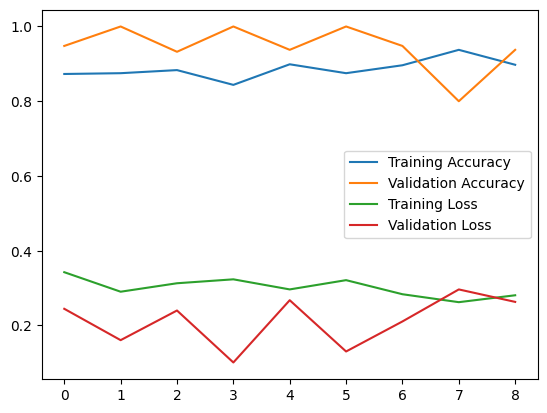

In [19]:
# Plot training history
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()


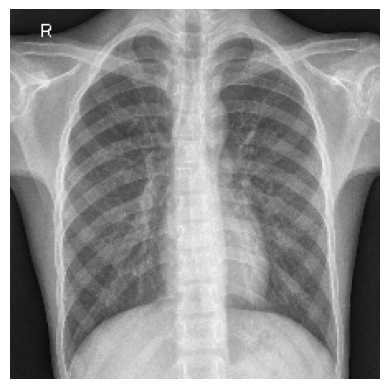

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Prediction: Normal (Confidence: 0.6635)


In [21]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

# Path to the saved model file
model_path = 'covid_detection_resnet50.h5'  # Replace with your model file path if different
model = load_model(model_path)

# Define image size
image_size = (224, 224)  # Size expected by the ResNet-50 model

# Function to preprocess and predict a single image
def predict_image(img_path, model):
    # Load the image
    img = image.load_img(img_path, target_size=image_size)
    
    # Display the image
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    
    # Preprocess the image
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Rescale the image

    # Make a prediction
    prediction = model.predict(img_array)
    
    # Convert prediction to class label
    if prediction > 0.5:
        result = "Normal"
    else:
        result = "COVID"
    
    print(f"Prediction: {result} (Confidence: {prediction[0][0]:.4f})")

# Path to the new image file
img_path = 'D:/sample/data/splitdata/val/Normal/IM-0005-0001.jpeg'  # Replace with the path to your test image

# Predict and display the result
predict_image(img_path, model)
